# Includes

In [1]:
import pandas as pd
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
%matplotlib inline

import os
import re
from datetime import datetime, timedelta
import numpy as np
from math import ceil, floor

In [2]:
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# Load data

In [3]:
root_path = ""
data_dir = os.path.join(root_path, "unpacked")

data_files = os.listdir(data_dir)  # target files
data_files = [x for x in data_files if x != 'readme.txt']  # remove readme


def file_to_df(file):
    """Open file and create pandas data frame"""
    full_path = os.path.join(data_dir, file)
    return pd.read_csv(full_path, sep=';')

In [4]:
print(data_files)

['vehicle19_fuelLevel_public.csv', 'vehicle19_ingection_public.csv', 'vehicle19_refueling2_public.csv', 'vehicle19_speedAndHeight_public.csv', 'vehicle19_tachometer_public.csv', 'vehicle1_fuelLevel_public.csv', 'vehicle1_ingection_public.csv', 'vehicle1_refueling2_public.csv', 'vehicle1_speedAndHeight_public.csv', 'vehicle1_tachometer_public.csv', 'vehicle28_fuelLevel_public.csv', 'vehicle28_ingection_public.csv', 'vehicle28_refueling2_public.csv', 'vehicle28_speedAndHeight_public.csv', 'vehicle28_tachometer_public.csv', 'vehicle3_fuelLevel_public.csv', 'vehicle3_ingection_public.csv', 'vehicle3_refueling2_public.csv', 'vehicle3_speedAndHeight_public.csv', 'vehicle3_tachometer_public.csv', 'vehicle5_fuelLevel_public.csv', 'vehicle5_ingection_public.csv', 'vehicle5_refueling2_public.csv', 'vehicle5_speedAndHeight_public.csv', 'vehicle5_tachometer_public.csv']


## Get vehicle IDs

In [5]:
regex_pattern = r"vehicle(\d*)"  # ID is integer number comes right after vehicle word
compiled_pattern = re.compile(regex_pattern)
ids = compiled_pattern.findall(''.join(data_files))  # apply pattern to all file names
ids = set(ids)  # get a set of unique numbers
print(ids)

{'19', '1', '3', '28', '5'}


## Load info about a single vehicle

In [6]:
def open_file_id(v_id, key_lexem):
    """Key lexem determines file, for example, 'fuelLevel'"""
    regex_pattern = re.compile(f"(vehicle{v_id}_{key_lexem}" + r"_(\w|\d|_)*\.csv)")  # pattern to find appropriate name
    pattern_match = regex_pattern.search('|'.join(data_files))  # search on a whole file set
    needed_file = pattern_match.group(1)  # the file is found, now we can open it
    return file_to_df(needed_file)
    
possible_lexems = ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer']

In [7]:
def load_all_files_id(v_id):
    """Generates a dictionary of all files describing a single vehicle"""
    return {lex: open_file_id(v_id, lex) for lex in possible_lexems}

# Task 4 - the mode of transportation of goods

In [8]:
  def plot_regplot(data, feature1, feature2, name):
    plt.figure(figsize=(10, 8))
    sns.regplot(x=feature1, y=feature2, data=data)
    plt.title(f'{feature1} and {feature2} relationship for {name} car')
    plt.grid()
    plt.show()

In [9]:
raw_data_base = {v_id: load_all_files_id(v_id) for v_id in ids}  # load all data

Очевидно, что отличительной чертой перевозки грузоа является большая масса, соответсвенно большая нагрузка на двигатель.
В связи с этим, я думаю, что из имеющихся у нас данных логичнее будет рассматривать показатния тахометра и скорости. Т.к. для поддержания одинаковой скорости, потребуется большее число оборотов (рассматривая движение на одной передаче). Думаю, для решения этой задачи было бы полезно иметь занчение ускорения в данный момент времени, и пройденное расстояние за какой-то период времени (тогда можно было бы еще ориентироваться на расход топлива)

In [10]:
dataset = {}
for i in ids:
    df = raw_data_base[i]['speedAndHeight'].copy()
    df['tachometer'] = raw_data_base[i]['tachometer']['BEVALUE']
    df['HEIGHT'] = df['HEIGHT'].apply(lambda x: float(re.sub(',','.',str(x))))
    df['DTIME'] = pd.to_datetime(df['DTIME'])
    df['date'] = df['DTIME'].apply(lambda x: x.date())
    df['time'] = df['DTIME'].apply(lambda x: x.time())
    dataset[i] = df.copy()

Давайте для всех транспортных стредств посмотрим связь оборотов и скорости.

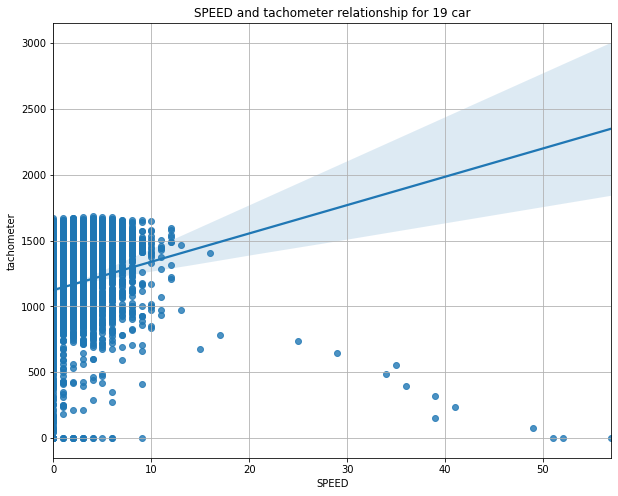

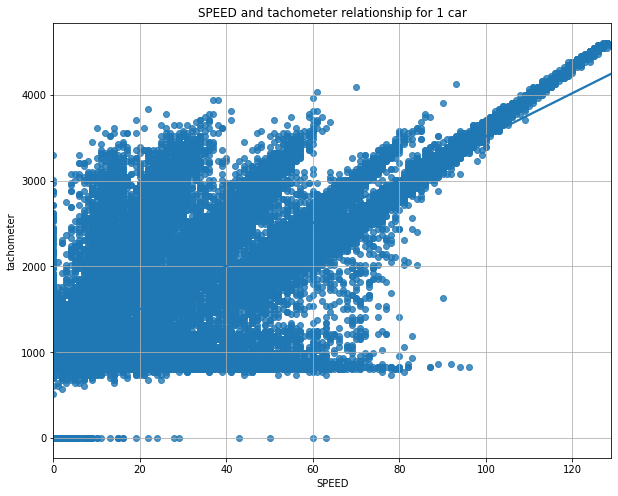

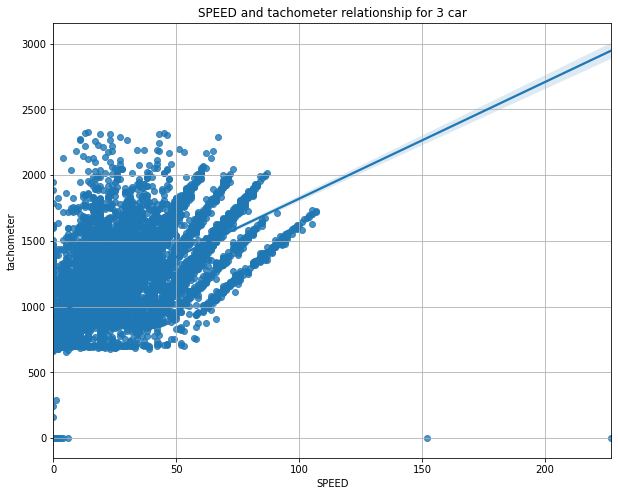

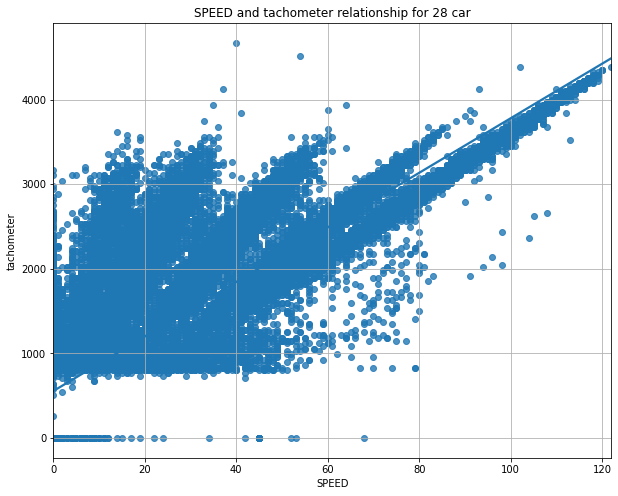

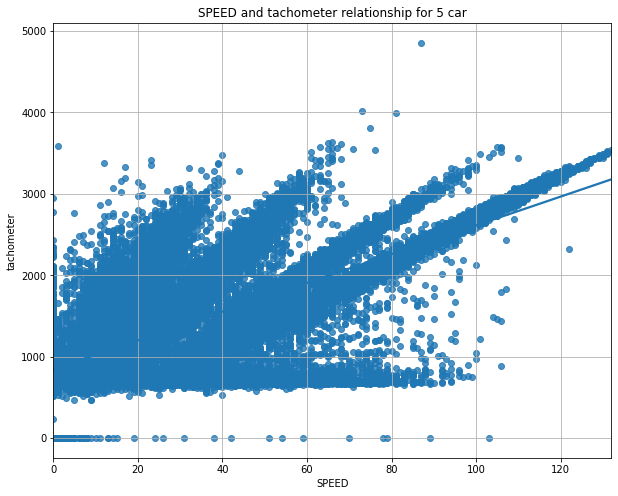

In [11]:
for name in dataset:
    plot_regplot(dataset[name], 'SPEED', 'tachometer', name)

Очевидно, что ТС 19 не имеет отношения к грузоперевозкам.

Заметна "зубчатость" графиков. Пологаю, что это либо движение с разной массой, либо движение на разных передачах.

## LinReg

### method 1

Этот метод решения заключается в разделении пространства на гиперплоскостью, в нашем случае прямой. Где обороты выше, там соответсвенно и больше масса.

In [192]:
def linreg(data, features, target, name):
    print()
    print('-'*40 + f'CAR {name}' + '-'*40)
    print()
    
    data = data.copy()
    skm = LinearRegression(normalize=True)
    skm.fit(data[features], data[target])
    pred = skm.predict(data[features])
    
    data['mode'] = ['empty' if t > y else 'cargo' for t, y in zip(pred, data[target])]
    
    text = f'the mode of transportation for {name} car'
    
    plt.figure(figsize=(10,10 ))
    
    
    sns.lmplot('SPEED', 'tachometer', data=data, hue='mode', fit_reg=False, scatter_kws=dict(alpha=0.7))
    
    plt.title(text)
    plt.grid()
    plt.show()
    
    fg = sns.lmplot('SPEED', 'tachometer', data=data, hue='mode', col='mode', fit_reg=False)
    
    

    for ax in fg.axes[0]:
        ax.set_title(text + '\n' + ax.title.get_text())
        ax.grid(b=True, which='major')
    plt.show()


----------------------------------------CAR 19----------------------------------------



<Figure size 720x720 with 0 Axes>

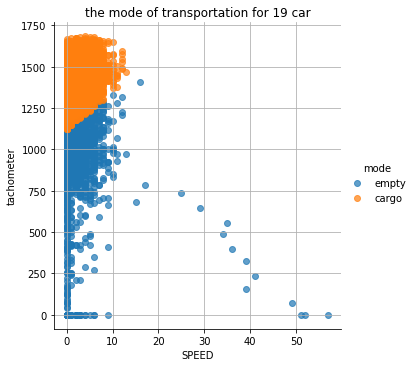

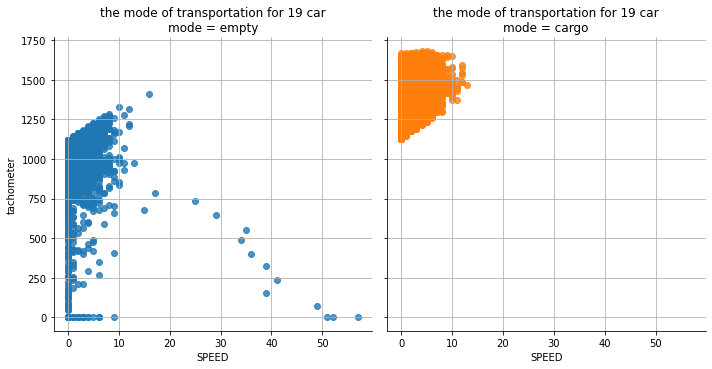


----------------------------------------CAR 1----------------------------------------



<Figure size 720x720 with 0 Axes>

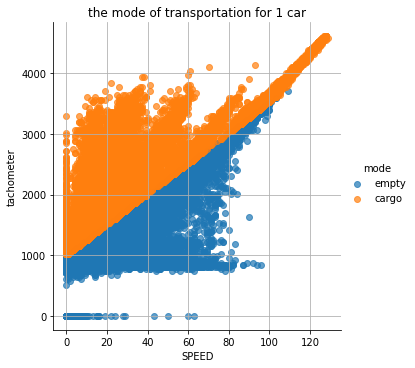

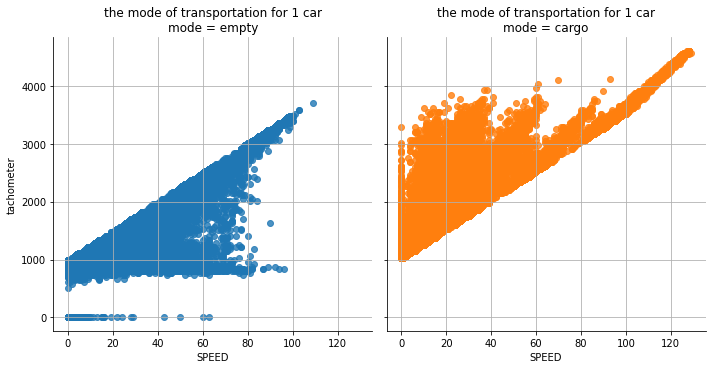


----------------------------------------CAR 3----------------------------------------



<Figure size 720x720 with 0 Axes>

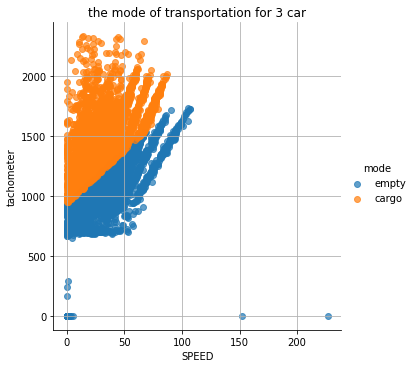

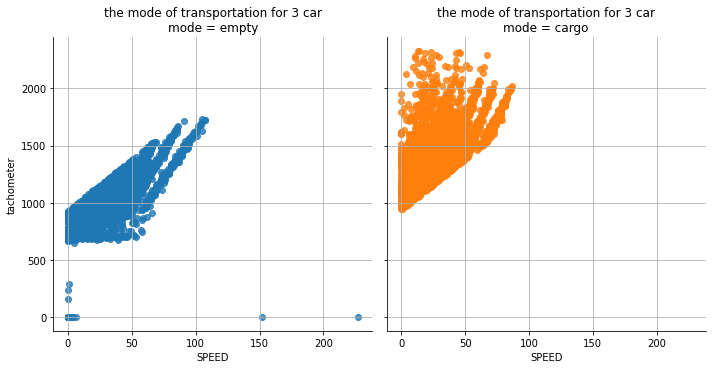


----------------------------------------CAR 28----------------------------------------



<Figure size 720x720 with 0 Axes>

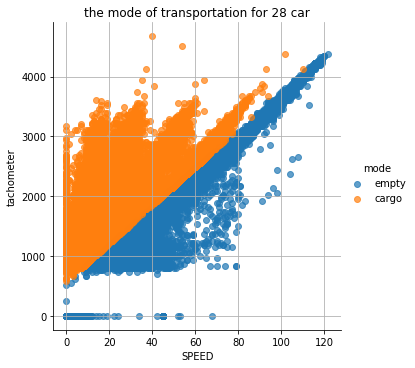

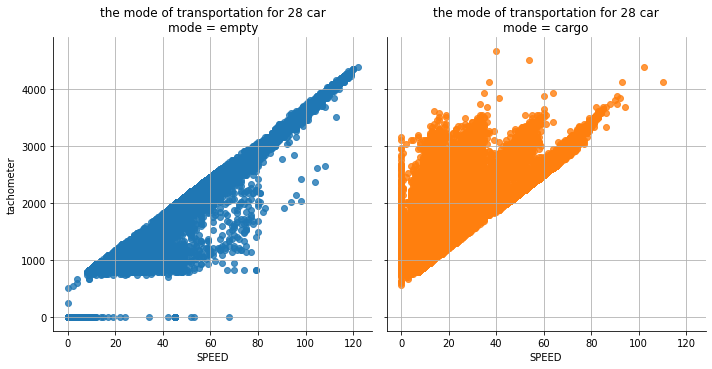


----------------------------------------CAR 5----------------------------------------



<Figure size 720x720 with 0 Axes>

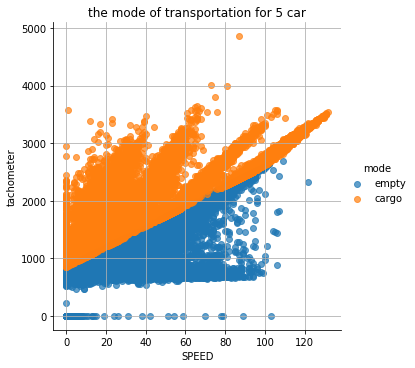

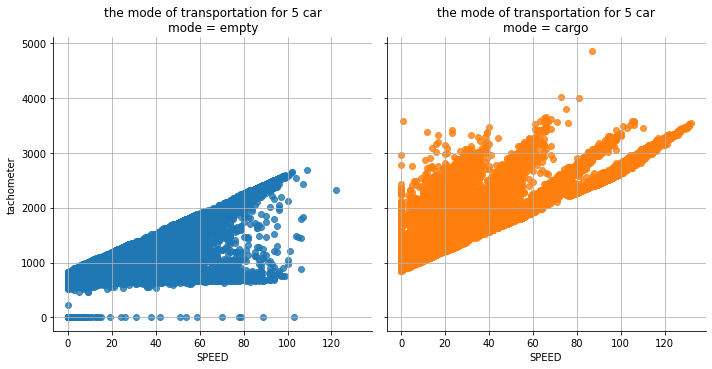

In [193]:
for name in dataset:
    linreg(dataset[name], ['SPEED'], 'tachometer', name)
    

Очень грубые результаты... Это не похоже на хорший вариант решения этой задачи

### method 2

Проверим что же это за "зубчатость" 

Построим этй же зависимость для одного из транспортных средств за один день

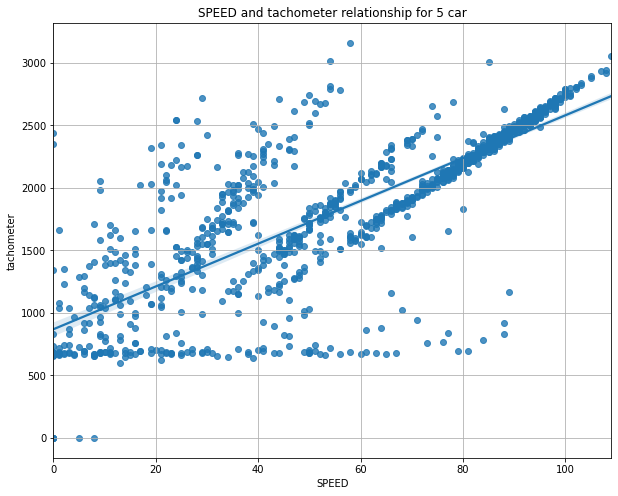

In [187]:
df = dataset['5'].copy()
plot_regplot(df[df['date'] == df['date'].unique()[1]], 'SPEED', 'tachometer', name)

Похоже, что это все-таки передачи, т.к. так часто менять груз за день очень странное занятие

Выше было упомянуто про ускорение, давайте попробуем получить что-то имеющее к этому отношение. У нас есть время и изменение скоррости за этот промежуток, воспользуемся этим.

In [188]:
def get_a(data):
    data = data.copy()
    num = 0
    time = data['DTIME'][0]
    s=[]
    for v, t in zip(data['SPEED'], data['DTIME']):
        s.append((v-num)/((t-time).total_seconds()+1e-9))
        time = t
        num = v
    return s

Так же рассчитаем изменение оборотов за этот же период времени, но т.к. мощность двигателя нелинейно зависит от оборотов, добавим логарифм

In [189]:
def get_dt(data):
    data = data.copy()
    num = 0
    s=[]
    for p in data['tachometer']:
        val = np.log(p+1)
        s.append(val-num)
        num = val
    return s


----------------------------------------CAR 19----------------------------------------



<Figure size 720x720 with 0 Axes>

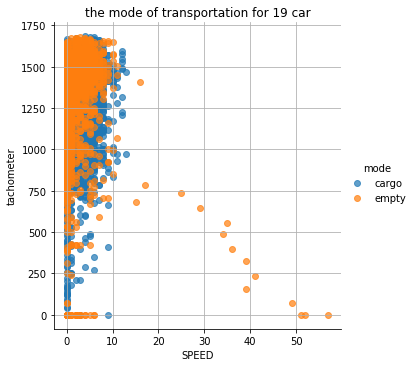

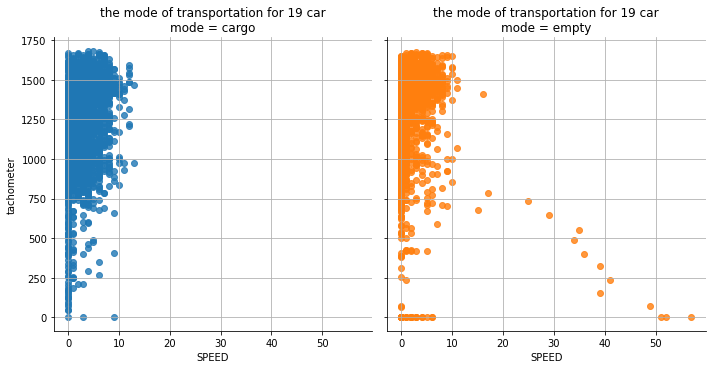


----------------------------------------CAR 1----------------------------------------



<Figure size 720x720 with 0 Axes>

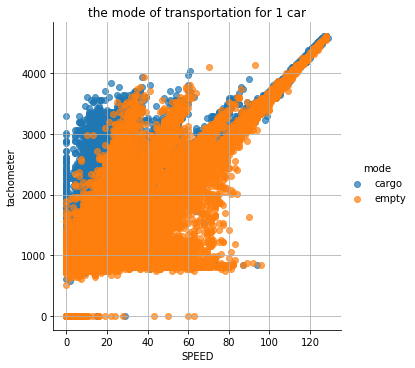

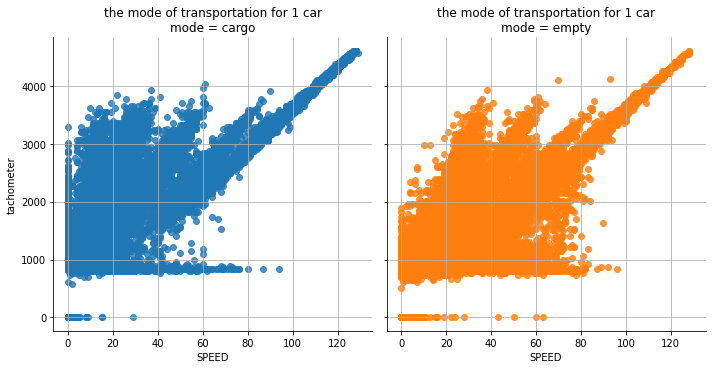


----------------------------------------CAR 3----------------------------------------



<Figure size 720x720 with 0 Axes>

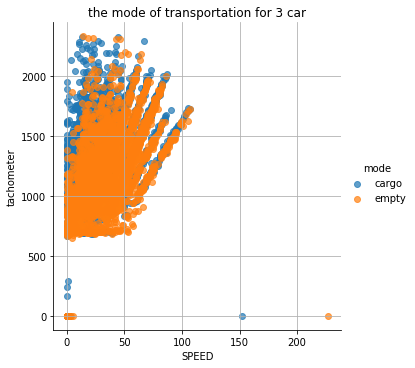

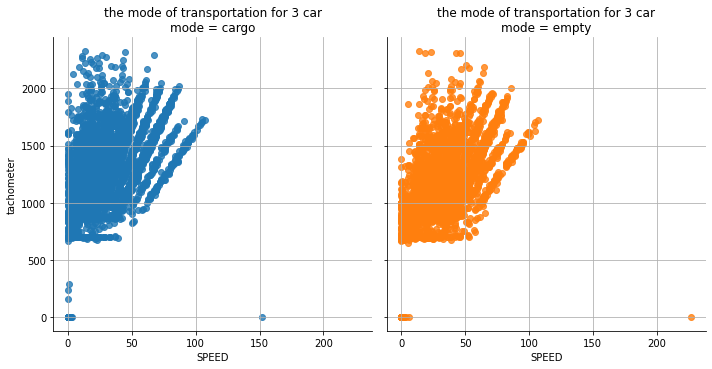


----------------------------------------CAR 28----------------------------------------



<Figure size 720x720 with 0 Axes>

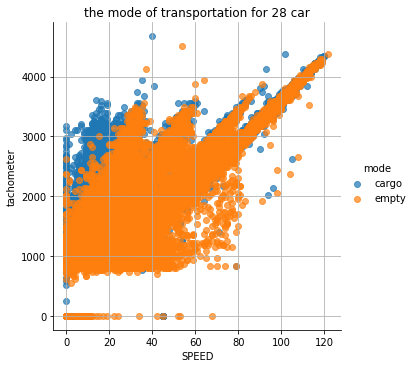

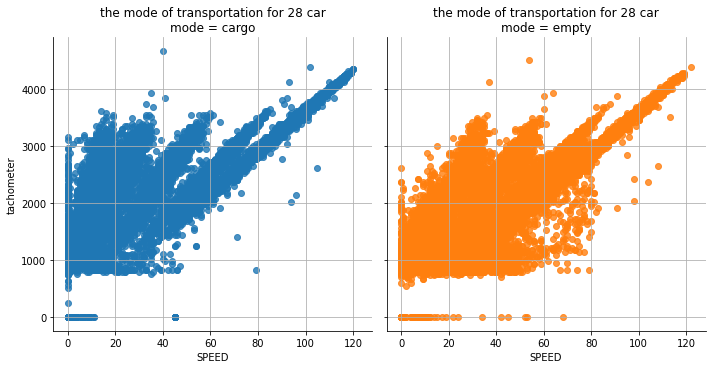


----------------------------------------CAR 5----------------------------------------



<Figure size 720x720 with 0 Axes>

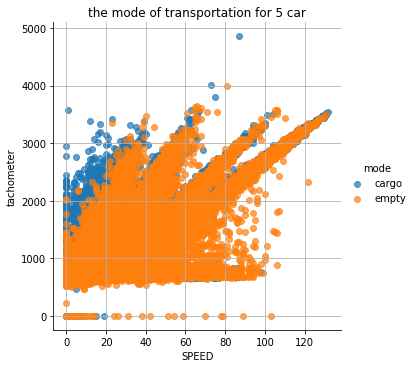

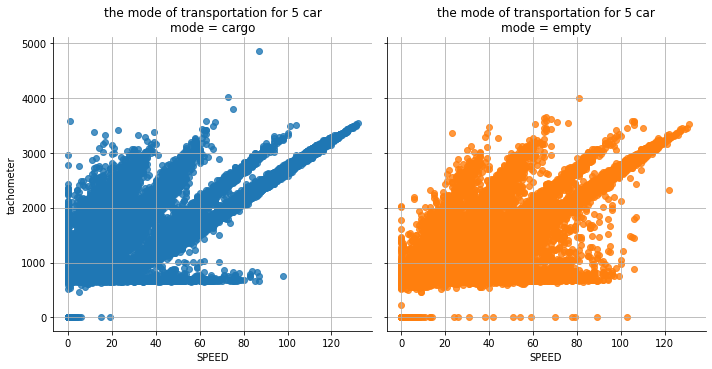

In [194]:
for name in dataset:
    data = dataset[name]
    data['a'] = get_a(data)
    data['dt'] = get_dt(data)
    linreg(data, ['a'], 'dt', name)

Оценить на правильность достоточно сложно, но видим, что на малых скоростях преобладает режим без груза, как, собственно, и ожидалось.

Подиножества уже схожи, это тоже говорит нам о том, что этот метод лучше

### method 3

А давайте еще учитывать набор и снижение высоты

Будем вычислять среднюю вертиальную скорость 

In [59]:
def get_dh(data):
    data = data.copy()
    num = data['HEIGHT'][0]
    time = data['DTIME'][0]
    s=[]
    for v, t in zip(data['HEIGHT'], data['DTIME']):
        s.append((v-num)/((t-time).total_seconds()+1e-9))
        time = t
        num = v
    return s

И построим зависимость не от одной величины как в предыдущем случае, а сразу от нескольких.

Логика этого метода в следующем: по заданным ускорению, изменению высоты и показаниям тахлметра пытаемся предсказать изменение оборотов. Если обороты возросли не так сильно, как мы предсказали, значит потребовалось меньше мощности, и масса у ТС не велика. Если же наоборот обороты возрасли сильнее, то масса, соответсвенно больше.


----------------------------------------CAR 19----------------------------------------



<Figure size 720x720 with 0 Axes>

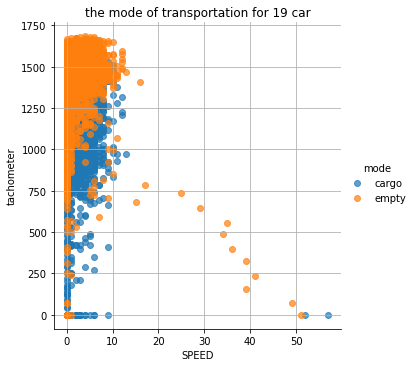

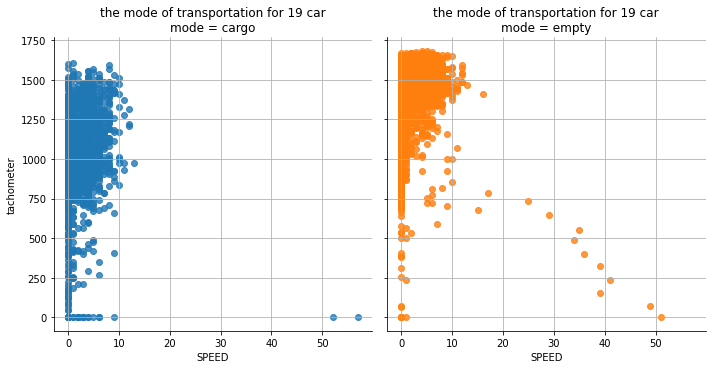


----------------------------------------CAR 1----------------------------------------



<Figure size 720x720 with 0 Axes>

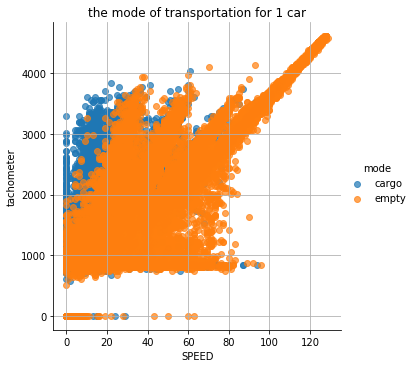

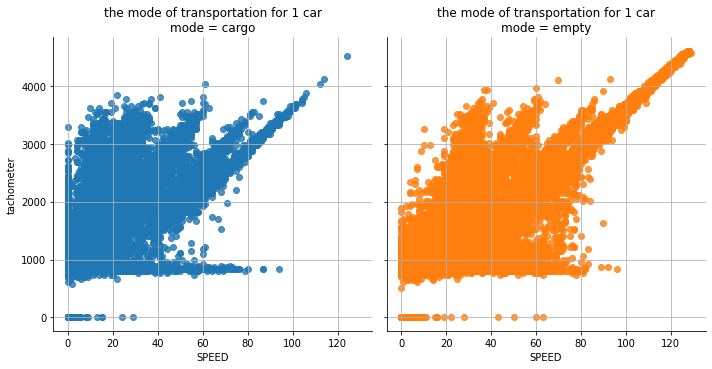


----------------------------------------CAR 3----------------------------------------



<Figure size 720x720 with 0 Axes>

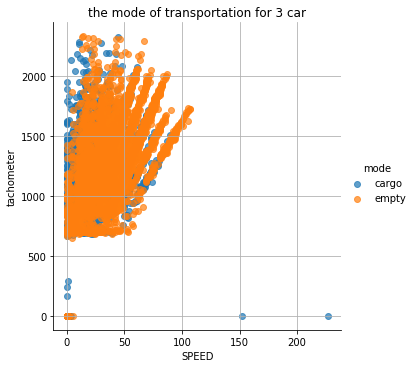

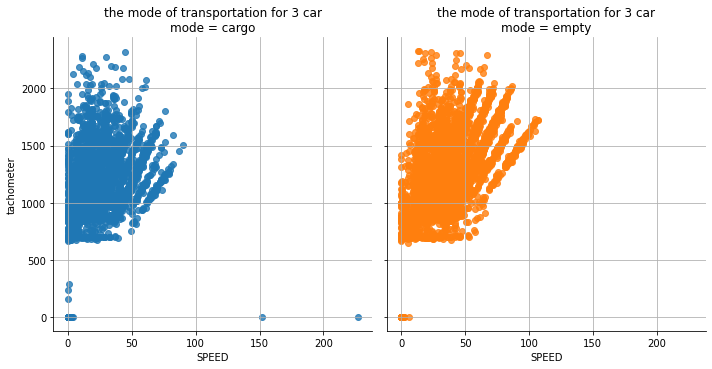


----------------------------------------CAR 28----------------------------------------



<Figure size 720x720 with 0 Axes>

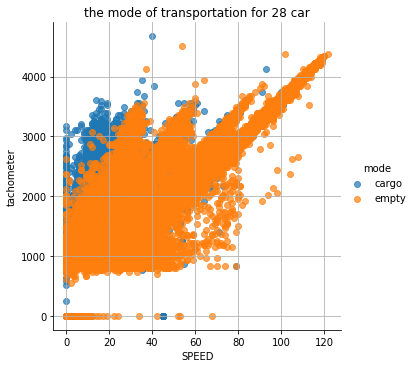

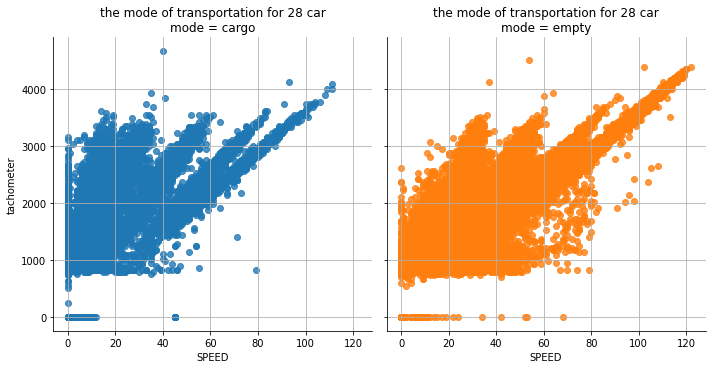


----------------------------------------CAR 5----------------------------------------



<Figure size 720x720 with 0 Axes>

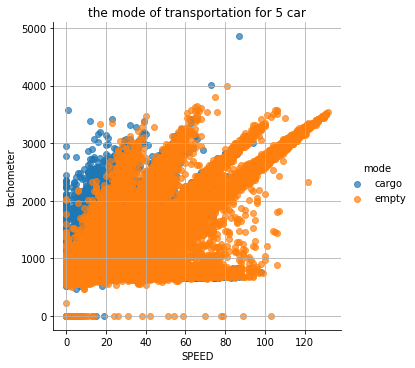

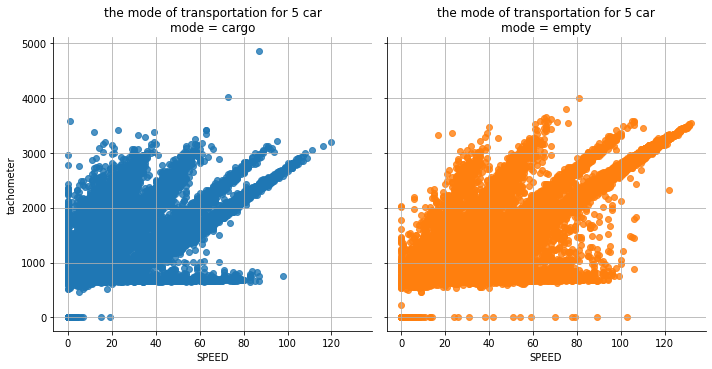

In [195]:
for name in dataset:
    data = dataset[name]
    data['dh'] = get_dh(data)
    linreg(data, ['a', 'dh', 'tachometer'], 'dt', name)

Результаты уже совсем похожи на правду (на мой взгляд)
* достижимы скорости на каждой передаче ниже с грузом
* большая смещенность к низким скоростям у груженых ТС при одинаковых показаниях тахометра

## KMin

Попробеум библиотечный метод кластеризации

In [197]:
data = dataset['5'].drop(['DTIME', 'date', 'time'], axis=1)

In [198]:
x = MinMaxScaler().fit_transform(data)

In [199]:
reducer =  umap.UMAP(random_state=1)
embedding =  reducer.fit_transform(x)
embedding

array([[16.115036 ,  1.6847929],
       [16.115204 ,  1.6845316],
       [16.11471  ,  1.6845605],
       ...,
       [17.164814 ,  2.9421766],
       [17.164845 ,  2.9421043],
       [16.703087 ,  1.4079899]], dtype=float32)

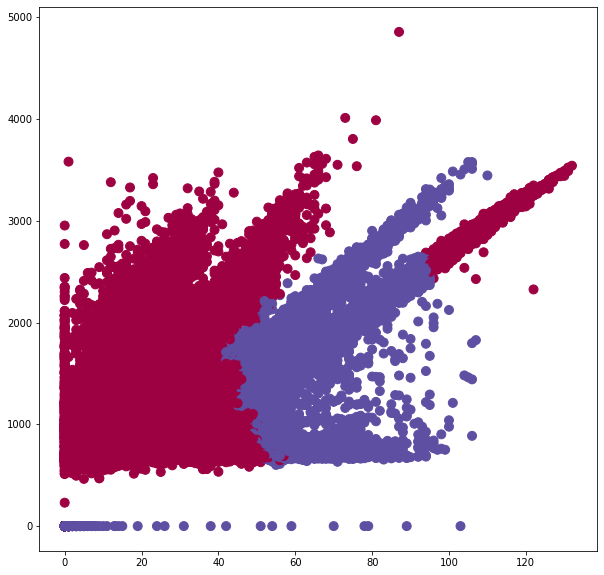

In [200]:
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(embedding)
labels = kmeans_model.labels_


plt.figure(figsize=(10,10 ))
plt.scatter(
    data['SPEED'], 
    data['tachometer'],  
    c= labels,  
    s= 80,  
    cmap= 'Spectral');

KMin показал себя не лучшим образом 

# Summary

На мой взгляд, метод номер 3, использующий линейную регрессию, показал достаточно хорший результат. Базовые алгоритмы кластеризации работают на данной задаче плохо.